<a href="https://colab.research.google.com/github/Itsuki-Hamano123/auto_ml/blob/master/tool_comparison/adult_census/autokeras_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -q git+https://github.com/keras-team/keras-tuner.git@1.0.2rc3
%pip install -q autokeras
%pip show keras-tuner autokeras scikit-learn

     |████████████████████████████████| 143kB 9.5MB/s 
     |████████████████████████████████| 849kB 22.8MB/s 
     |████████████████████████████████| 1.1MB 38.8MB/s 
     |████████████████████████████████| 36.7MB 87kB/s 
     |████████████████████████████████| 358kB 53.3MB/s 
     |████████████████████████████████| 174kB 55.9MB/s 
     |████████████████████████████████| 102kB 14.2MB/s 
Name: keras-tuner
Version: 1.0.2rc3
Summary: Hypertuner for Keras
Home-page: https://github.com/keras-team/keras-tuner
Author: The Keras Tuner authors
Author-email: kerastuner@google.com
License: Apache License 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: future, terminaltables, packaging, tqdm, scipy, scikit-learn, colorama, tabulate, numpy, requests
Required-by: 
---
Name: autokeras
Version: 1.0.10
Summary: AutoML for deep learning
Home-page: http://autokeras.com
Author: Data Analytics at Texas A&M (DATA) Lab, Keras Team
Author-email: jhfjhfj1@gmail.com
License: MIT
Location: /usr/lo

[国税調査データセット:https://www.openml.org/d/1590](https://www.openml.org/d/1590)

In [2]:
import datetime, IPython, os 

import numpy as np
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from autokeras import StructuredDataClassifier
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

# データ読み込み

In [3]:
%%time
DATA_ID = '1590' #@param{type:'string'}

# データセットをフェッチ
result = fetch_openml(data_id=DATA_ID,
                    as_frame=True)
X = result.data
y = result.target
x_cols = result.feature_names
y_col = result.target_names

display(x_cols)
display(X.head())
display(y_col)
display(y.head())


def proc_y(y):
    '''ラベルの加工'''

    def _label_encode(y):
        '''ラベルエンコードしたnumpy.ndarrayを返す'''
        le = LabelEncoder()
        le.fit(y)
        return le.transform(y)

    proc_y = _label_encode(y=y)
    return proc_y


def proc_X(X, one_hot_encode_cols):
    '''特徴量の加工'''

    def _one_hot_encode(X, X_cols, drop_first=True):
        '''ワンホットエンコードしたDataframeを返す'''
        return pd.get_dummies(X, columns=X_cols,
                              drop_first=drop_first)

    proc_X = _one_hot_encode(X=X, X_cols=one_hot_encode_cols)
    return proc_X


one_hot_encode_cols = ['workclass', 'education', 'marital-status', 'occupation',
                       'relationship', 'race', 'sex', 'native-country']
#X=proc_X(X=X, one_hot_encode_cols=one_hot_encode_cols)
y=proc_y(y=y)

display(X.head())
display(y)


SEED = 7 #@param{type:'number'}
SPLIT = 0.2 #@param{type:'number'}

train_X, test_X, train_y, test_y = train_test_split(X, y,
                                                    test_size=SPLIT,
                                                    random_state=SEED,
                                                    shuffle=True)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y,
                                                  test_size=SPLIT,
                                                  random_state=SEED,
                                                  shuffle=True)

display('train shape:{}'.format(train_X.shape))
display('val shape:{}'.format(val_X.shape))
display('test shape:{}'.format(test_X.shape))



['age',
 'workclass',
 'fnlwgt',
 'education',
 'education-num',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'native-country']

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States
4,18.0,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States


['class']

0    <=50K
1    <=50K
2     >50K
3     >50K
4    <=50K
Name: class, dtype: category
Categories (2, object): ['>50K', '<=50K']

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States
4,18.0,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States


array([0, 0, 1, ..., 0, 0, 1])

'train shape:(31258, 14)'

'val shape:(7815, 14)'

'test shape:(9769, 14)'

CPU times: user 1.24 s, sys: 53.6 ms, total: 1.3 s
Wall time: 2.92 s


# モデル構築

In [4]:
# 探索アルゴリズムの試行回数
MAX_TRIALS =  5#@param{type:'number'}

clf = StructuredDataClassifier(overwrite=True,
                               max_trials=MAX_TRIALS,
                               seed=SEED)
display(clf)


# 各モデルのepoch数
EPOCH =  100#@param{type:'number'}
BATCH_SIZE = 1024#@param{type:'number'}

# 早期停止コールバックの定義
es = EarlyStopping(monitor='val_loss',
                   patience=2)

In [5]:
%%time
clf.fit(x=train_X, y=train_y, epochs=EPOCH,
        batch_size=BATCH_SIZE,
        validation_data=(val_X, val_y),
        callbacks=[es])

Trial 5 Complete [00h 00m 31s]
val_accuracy: 0.8510556817054749

Best val_accuracy So Far: 0.8514395356178284
Total elapsed time: 00h 02m 13s
INFO:tensorflow:Oracle triggered exit
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./structured_data_classifier/best_model/assets
CPU times: user 2min 43s, sys: 12.3 s, total: 2min 55s
Wall time: 2min 23s


# ベストなモデルの可視化

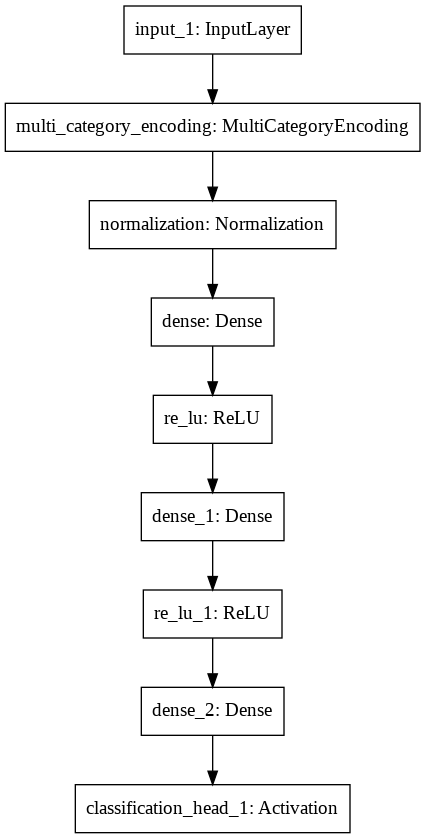

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 14)]              0         
_________________________________________________________________
multi_category_encoding (Mul (None, 14)                0         
_________________________________________________________________
normalization (Normalization (None, 14)                29        
_________________________________________________________________
dense (Dense)                (None, 32)                480       
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32)               

None

In [6]:
def display_best_model(ak_model):
    '''ベストなモデルの構造を表示'''
    best_model = ak_model.export_model()
    display(plot_model(best_model))
    display(best_model.summary())


display_best_model(ak_model=clf)

# モデルの評価

In [7]:
def take_best_model(ak_model):
    '''ベストなモデルを取り出し'''
    best_model = ak_model.export_model()
    return best_model


model = take_best_model(ak_model=clf)

## Kerasの組み込み評価関数

In [12]:
%%time
score = model.evaluate(x=test_X.astype('unicode'), y=test_y, batch_size=256)
display('loss : {}, accuracy : {}'.format(score[0], score[1]))

39/39 [==============================] - 0s 3ms/step - loss: 0.3376 - accuracy: 0.8467


'loss : 0.3375566601753235, accuracy : 0.8466578125953674'

CPU times: user 458 ms, sys: 26.3 ms, total: 485 ms
Wall time: 416 ms


## sklearnの評価関数

In [13]:
%%time
def predict_classes(model, X):
    '''ラスラベルの予測を取得
    INFO : 二項分類モデル用'''
    return np.where(model.predict(X)<0.5, 0, 1)


# 予測結果の取得
train_y_pred = predict_classes(model, train_X.astype('unicode'))
val_y_pred = predict_classes(model, val_X.astype('unicode'))
test_y_pred = predict_classes(model, test_X.astype('unicode'))


train_report = classification_report(y_true=train_y, y_pred=train_y_pred)
val_report = classification_report(y_true=val_y, y_pred=val_y_pred)
test_report = classification_report(y_true=test_y, y_pred=test_y_pred)

print(train_report)
print('----- -----')
print(val_report)
print('----- -----')
print(test_report)

              precision    recall  f1-score   support

           0       0.88      0.94      0.91     23781
           1       0.75      0.60      0.67      7477

    accuracy                           0.86     31258
   macro avg       0.81      0.77      0.79     31258
weighted avg       0.85      0.86      0.85     31258

----- -----
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      5915
           1       0.75      0.59      0.66      1900

    accuracy                           0.85      7815
   macro avg       0.81      0.76      0.78      7815
weighted avg       0.84      0.85      0.85      7815

----- -----
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      7459
           1       0.72      0.58      0.64      2310

    accuracy                           0.85      9769
   macro avg       0.80      0.75      0.77      9769
weighted avg       0.84      0.85      0.84      9